### Test case LVV-T1074 - Sky Brightness precision

The maximum error in the precision of the sky brightness determination shall be less than **SBPerc = 1** percent.

#### Discussion

This test can be run using data products produced during regular reprocessing campaigns executed by the Data Management pipelines team. Specifically, we will use the ComCam commissioning images in "/repo/embargo", found in Butler collection “LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128", and the regularly-reprocessed HSC RC2 data as reprocessed with weekly pipelines version w_2024_34, in Butler collection “HSC/runs/RC2/w_2024_34/DM-45857".

In [1]:
import numpy as np
from astropy.stats import sigma_clip as sc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output

from lsst.daf.butler import Butler
from lsst.pipe.tasks.background import MaskObjectsTask

We will measure this using the `calexp` images, executing the following *for each detector, for each test visit*:
 - Retrieve the sky-subtracted `calexp`
 - Convert image flux to nanojanskies
 - Measure and record the per-pixel standard deviation of the background pixel fluxes, ignoring masked detections and artifacts

Additionally, we will measure this using the `sourceTable_visit` tables, executing the following *for each test visit*:
 - Trim the `sourceTable_visit` tables to include only sky objects
 - Divide the summed `ap09Flux` fluxes by the circular aperture area to derive the mean fluxes within each aperture
 - Measure and record the standard deviation of these sky object mean fluxes (equivalent to the standard deviation of an image binned by the aperture area)
 - Correct these mean fluxes by $\sqrt{N}$, where $N$ is the number of pixels in the measurement aperture, to estimate the per-pixel standard deviation equivalent to that measured from the image background directly
 - Record the ratios between the standard deviations of the image backgrounds and sky object fluxes to the visit's mean sky brightness, derived as the mean of the `calexp` metadata `BGMEAN` parameters for all CCDs

Image and metadata retrieval is wrapped into a function called `retrieveImage`, and sky object retrieval is wrapped into a function called `retrieveSkyObjects`, in the following two cells:

In [2]:
def retrieveImage(dataId, collection):
    '''Retrieves the sky-subtracted calibrated exposure and associated metadata.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored

    Returns
    -------
    calexp : `ImageF`
        Calexp with the `calexpBackground` subtracted from it, converted to nJy flux
    `metaData` : `dict`
        Dictionary of calexp metadata, including mean BG flux (in nJy)
    '''
    # Retrieve the image, metadata, and calibration
    calexp = butler.get("calexp",
                         dataId=dataId,
                         collections=collection,
                       )
    metaData = calexp.info.getMetadata().toDict()
    photoZp = calexp.getPhotoCalib().instFluxToNanojansky(1)

    # Convert everything to nanojansky
    calexp.image.array *= photoZp
    metaData["BGMEAN"] *= photoZp
    metaData["BGVAR"] *= photoZp

    return calexp, metaData

In [3]:
def retrieveSkyObjects(dataId, collection, aper=9):
    '''Retrieve the sky objects aperture fluxes for a given detector, for
    a given detector in a given visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    aper : `int`
        Choice of sky object aperture radius.  Valid are 3,6,9,12,25,35,70
        9 is recommended as sky objects are defined as being >8px from the
        nearest detection.

    Returns
    -------
    skyObjs : pandas `Series`
        Total fluxes of sky objects within circular aperture of radius aper,
        nJy
    '''
    # Retrieve table
    srcTab = butler.get("sourceTable",
                        dataId=dataId,
                        collections=collection,
                       )
    isSky = (srcTab["sky_source"] > 0)  # Pick only sky objects
    skyObjs = srcTab[isSky]["ap%02dFlux" % (aper)]  # Units are nJy already

    return skyObjs

Estimation of the background and sky object standard deviations are wrapped into functions called `deriveBgNoise` and `deriveObjNoise`, in the following cells:

In [4]:
def deriveBgNoise(dataId, collection):
    '''Derives the clipped standard deviation of the background of the
    sky-subtracted calexps for a single visit.

    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored

    Returns
    -------
    sigSkyBg : `float`
        Clipped standard deviation of sky-subtracted background flux, nJy
    noiseFracBg : `float`
        Ratio between sigSkyBg and mean sky brightness of exposure
    '''
    # Retrieving images and metadata
    ssImage, metaData = retrieveImage(dataId, collection)

    # Masking the sky-subtracted image of sources/other things
    mask = ssImage.maskedImage.mask
    bad_mask_bit_mask = mask.getPlaneBitMask(badMaskPlanes)
    good = (mask.array.astype(int) & bad_mask_bit_mask) == 0

    # Sigma-clipping the background pixel fluxes
    clipSkyBackground = sc(ssImage.image.array[good], sigma=3, maxiters=3, masked=False)

    sigSkyBg = np.nanstd(clipSkyBackground)  # 1 sigma value, per pixel

    # Sky accuracy estimates
    noiseFracBg = sigSkyBg / metaData["BGMEAN"]

    return sigSkyBg, noiseFracBg

In [5]:
def deriveObjNoise(dataId, collection, bgMean, aper=9):
    '''Derives the clipped standard deviation of the sky objects for a
    single visit.
    
    Parameters
    ----------
    dataId : `dict`
        Dictionary containing "visit", "detector", and "instrument" values for
        image retrieval
    collection : `str`
        Name of the collection in which the desired images are stored
    bgMean : `float`
        BGMEAN parameter for the corresponding detector
    aper : `int`
        Choice of sky object aperture radius.  See retrieveSkyObjects()

    Returns
    -------
    sigSkyObj : `float`
        Clipped standard deviation of mean sky object fluxes within aperture,
        nJy
    noiseFracObj : `float`
        Ratio between sigSkyObj and mean sky brightness of exposure
    '''
    # Retrieving catalog
    skyObjs1 = retrieveSkyObjects(dataId, collection, aper)

    # Sigma-clipping the mean fluxes within sky object apertures
    nPix = np.pi*aper**2  # Number of pixels per aperture
    clipSkyObjs = sc(skyObjs1/nPix, sigma=3, maxiters=3, masked=False)

    # The distribution of the mean fluxes within 9px radius apertures is equivalent
    # to the distribution of a binned version of the image, i.e. std is reduced by
    # the bin factor.  So we take that out to compare against the per-pixel std.
    sigSkyObj = np.nanstd(clipSkyObjs) * np.sqrt(nPix)

    # Sky accuracy estimate
    noiseFracObj = sigSkyObj / bgMean

    return sigSkyObj, noiseFracObj

Run the following cell to initialize the notebook for ComCam images.

In [6]:
# Initialize the butler repo pointing to the DM-48128 (w_2024_50) collection
repo = "/repo/embargo"
collection = "LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128"
instrument = "LSSTComCam"
detectors = list(range(9))

butler = Butler(repo, collections=collection)

# Find the visit IDs
refs = butler.query_datasets("sourceTable_visit", collections=collection)
# Limit to g-band visits
visits = [x.dataId["visit"] for x in refs if x.dataId["band"] == "g"]
# Reduce run-time by using a sub-sample of all visits
visits = visits[:100]

Or run the following cell to initialize the notebook for HSC images.

In [7]:
# Initialize the butler repo pointing to the DM-45857 (w_2024_34) collection
repo = "/repo/main"
collection = "HSC/runs/RC2/w_2024_34/DM-45857"
instrument = "HSC"
detectors = list(range(104))
detectors.remove(9)  # Faulty CCD in HSC

butler = Butler(repo, collections=collection)

# Find the visit IDs
refs = butler.query_datasets("sourceTable_visit", collections=collection)
# Limit to g-band visits
visits = [x.dataId["visit"] for x in refs if x.dataId["band"] == "g"]
# Reduce run-time by using a sub-sample of all visits
visits = visits[:5]  # Larger number of CCDs in HSC, so a smaller sub-sample is a good idea

In [8]:
# Set the mask planes to ignore, following defaults in `background.py` used by `skyCorr`
badMaskPlanes = ["SAT", "BAD", "EDGE", "DETECTED", "DETECTED_NEGATIVE", "NO_DATA"]

For *M* visits, derive the background standard deviations and noise ratios of all CCDs and collate into lists.

In [9]:
# Setting up a basic progress bar
pound = "#"
bounds = " "*(len(detectors)) + "| %d" % (1)

# Store results in a dictionary accessed by visit ID
noiseDict = {}
# Processing time here is long!
for i,vis in enumerate(visits):
    noiseDict[vis] = {"sigSkyObj": [],
                      "sigSkyBg": [],
                      "noiseFracObj": [],
                      "noiseFracBg": []}
    # Reset progress bar per visit, label by iteration #
    if vis != visits[0]:
        pound = "#"
        bounds = " "*(len(detectors)) + "| %d" % (i+1)
    for det in detectors:
        dataId = {"visit": vis, "detector": det, "instrument": instrument}
        # Image backgrounds
        try:
            sigSkyBg, noiseFracBg = deriveBgNoise(dataId, collection)
            noiseDict[vis]["sigSkyBg"].append(sigSkyBg)
            noiseDict[vis]["noiseFracBg"].append(noiseFracBg)
            bgMean = sigSkyBg / noiseFracBg  # Mean of detector BG
        except:
            noiseDict[vis]["sigSkyBg"].append(np.nan)
            noiseDict[vis]["noiseFracBg"].append(np.nan)
            bgMean = sigSkyBg / noiseFracBg  # Mean of detector BG            

        # Sky objects
        try:
            sigSkyObj, noiseFracObj = deriveObjNoise(dataId, collection, bgMean)
            noiseDict[vis]["sigSkyObj"].append(sigSkyObj)
            noiseDict[vis]["noiseFracObj"].append(noiseFracObj)
        except:
            noiseDict[vis]["sigSkyObj"].append(np.nan)
            noiseDict[vis]["noiseFracObj"].append(np.nan)

        # Progress bar code
        clear_output(wait=True)
        display(pound+bounds)
        pound += "#"
        bounds = bounds[1:]

'#######################################################################################################'

For a random sub-sample of at least five visits (or all visits, if fewer than five total), print the standard deviations derived each way to the screen, and print the ratios between these and the mean background flux.

In [10]:
print("Standard deviations and ratios with mean background flux for five randomly chosen calexps")
print("==================================================================================")
rng = np.random.default_rng(12345)  # Arbitrary seed
if len(visits) < 5:
    idx = np.arange(len(visits))
else:
    idx = rng.choice(np.arange(len(visits)), size=5, replace=False)
keys = np.array(list(noiseDict.keys()))[idx]
for key in keys:
    idy = rng.choice(np.arange(9))  # Random detector ID
    print("Visit %d: sigBG=%.3f nJy, sigObjs=%.3f nJy, sigBG/fBG=%.3f, sigObjs/fObjs=%.3f"
          % (key, np.nanmean(noiseDict[key]["sigSkyBg"][idy]), noiseDict[key]["sigSkyObj"][idy],
            np.nanmean(noiseDict[key]["noiseFracBg"][idy]), noiseDict[key]["noiseFracObj"][idy]))

Standard deviations and ratios with mean background flux for five randomly chosen calexps
Visit 6320: sigBG=4.022 nJy, sigObjs=5.235 nJy, sigBG/fBG=0.025, sigObjs/fObjs=0.032
Visit 11692: sigBG=3.309 nJy, sigObjs=5.170 nJy, sigBG/fBG=0.016, sigObjs/fObjs=0.025
Visit 11696: sigBG=3.201 nJy, sigObjs=4.480 nJy, sigBG/fBG=0.015, sigObjs/fObjs=0.021
Visit 11694: sigBG=3.335 nJy, sigObjs=6.193 nJy, sigBG/fBG=0.016, sigObjs/fObjs=0.030
Visit 11690: sigBG=3.282 nJy, sigObjs=4.731 nJy, sigBG/fBG=0.016, sigObjs/fObjs=0.023


The standard deviation measured from the background measures the pixel-to-pixel uncertainty from the distribution of all background flux, while that measured from the sky objects measures the same uncertainty on larger (9px radius aperture) scales.  Larger standard deviations measured within apertures suggests that the backgrounds contain correlated flux, possibly leakage from detection or artifact masks.

The ratio between the standard deviation and the mean background flux subtracted from the images is a metric to measure the `SBPerc` metric specified in the requirement.  From this small sub-sample of test images, the requirement is not being met.

#### Plots

Create histograms of standard deviations and standard deviations normalized by the mean sky flux in each detector in each visit tested.

In [11]:
# Retrieve stored dictionary values as Numpy arrays
sigSkyBgs = np.array([noiseDict[visits[i]]["sigSkyBg"] for i in range(len(visits))]).flatten()
sigSkyObjs = np.array([noiseDict[key]["sigSkyObj"] for key in visits]).flatten()
noiseFracBgs = np.array([noiseDict[visits[i]]["noiseFracBg"] for i in range(len(visits))]).flatten()
noiseFracObjs = np.array([noiseDict[key]["noiseFracObj"] for key in visits]).flatten()

Text(0.5, 0, '$\\overline{\\sigma}_{\\rm BG}\\, /\\, \\overline{F}_{\\rm BG}$')

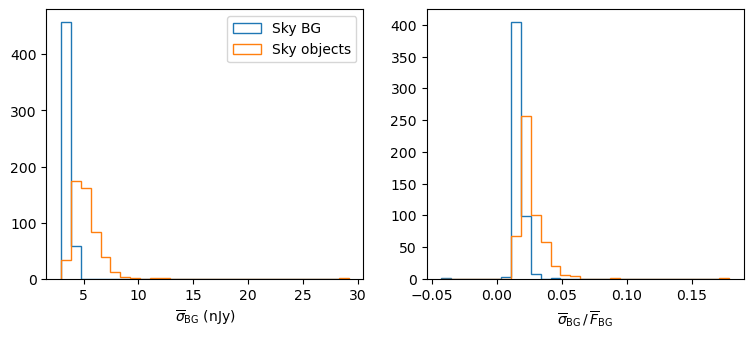

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))
# Standard deviation
N = 30  # Number of histogram bins
ax[0].hist(sigSkyBgs, np.linspace(np.nanmin(sigSkyBgs), np.nanmax(sigSkyObjs), N), histtype="step", label="Sky BG")
ax[0].hist(sigSkyObjs, np.linspace(np.nanmin(sigSkyBgs), np.nanmax(sigSkyObjs), N), histtype="step", label="Sky objects")
ax[0].legend()
ax[0].set_xlabel(r"$\overline{\sigma}_{\rm BG}$ (nJy)")

# Standard deviation / mean background flux
ax[1].hist(noiseFracBgs, np.linspace(np.nanmin(noiseFracBgs), np.nanmax(noiseFracObjs), N), histtype="step", label="Sky BG")
ax[1].hist(noiseFracObjs, np.linspace(np.nanmin(noiseFracBgs), np.nanmax(noiseFracObjs), N), histtype="step", label="Sky objects")
ax[1].set_xlabel(r"$\overline{\sigma}_{\rm BG}\, /\, \overline{F}_{\rm BG}$")

Create violin plots showing distributions of standard deviations in sky-subtracted backgrounds for each visit (left panel), and distributions of ratios between those standard deviations and the mean sky brightness (right panel).  Show the values derived from the image backgrounds as blue violins, and the values derived from the sky objects as orange violins.  To meet the requirements, the latter must be < 0.01 (red dotted line in right panel).  Red x's show same metrics  evaluated from sky objects.  To avoid clutter, display only 10 visits.

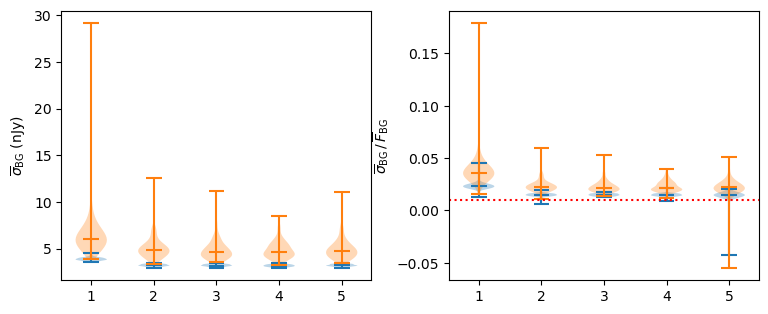

In [13]:
# Pick 10 visits of the full sample at random, or all if len < 10
if len(visits) < 10:
    idx = np.arange(len(visits))
else:
    idx = rng.choice(np.arange(len(visits)), size=10, replace=False)

fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))
# Standard deviation
# From background flux distributions
ax[0].violinplot([noiseDict[visits[i]]["sigSkyBg"] for i in idx],
                 showmedians=True)
# From sky objects
ax[0].violinplot([noiseDict[visits[i]]["sigSkyObj"] for i in idx],
                showmedians=True)
ax[0].set_ylabel(r"$\overline{\sigma}_{\rm BG}$ (nJy)")

# Standard deviation / mean background flux
# From background flux distributions
ax[1].violinplot([noiseDict[visits[i]]["noiseFracBg"] for i in idx],
                showmedians=True)
# From sky objects
ax[1].violinplot([noiseDict[visits[i]]["noiseFracObj"] for i in idx],
                showmedians=True)
ax[1].axhline(0.01, c="r", linestyle=":")
ax[1].set_ylabel(r"$\overline{\sigma}_{\rm BG}\, /\, \overline{F}_{\rm BG}$")
plt.subplots_adjust(wspace=0.25)

#### Results

We have demonstrated that the sky estimation precision metric `SBPerc` can be tested using `calexp` images, their associated `skyCorr` models, and the sky objects values stored in the `sourceTable_visit` tables produced by the Rubin Science Pipelines.  The result of this test is "**Fail**"; in no visits do we find that `SBPerc < 1`.